In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import average_precision_score
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


From EDA, it was observed that fraudulent transactions occur only in 'CASH_OUT' and 'TRANSFER', so we consider only the corresponding data for the analysis.

In [46]:
df = pd.read_csv('../data/onlinefraud.csv')
X = df[(df['type']=='CASH_OUT') | (df['type']=='TRANSFER')]
Y = X['isFraud']
X.drop(columns=['isFraud'], axis=1, inplace=True)

# Eliminat the columns that are not relevant for the analysis
X.drop(columns=['nameOrig', 'isFlaggedFraud', 'nameDest'], axis=1, inplace=True)

In [47]:
#Encode transaction type as binary
X.loc[X['type']=='TRANSFER', 'type'] = 0
X.loc[X['type']=='CASH_OUT', 'type'] = 1
X['type'] = X['type'].astype(int)


#### There are many zero balances in the destination account. Are those missing values?

Data has many zero balance in the destination acount both before and after a non-zero amount has been transferred. Such transactions are around 50% in fradulent and 0.06% in non-fraudulent transactions.

In [48]:
df_fraud = X.loc[Y==1]
df_nonfraud = X.loc[Y==0]

print(f"The fraction of fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: {len(df_fraud[(df_fraud['oldbalanceDest'] == 0) & (df_fraud['newbalanceDest']==0) & (df_fraud['amount']!=0)])/len(df_fraud)}")
print(f"The fraction of non-fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: {len(df_nonfraud[(df_nonfraud['oldbalanceDest'] == 0) & (df_nonfraud['newbalanceDest']==0) & (df_nonfraud['amount']!=0)])/len(df_nonfraud)}")


The fraction of fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: 0.4955558261293072
The fraction of non-fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: 0.0006176245277308345


Since the fraction of transactions where the destination balance is zero both before and after a non-zero amount has been transferred is high in fraudulent transactions (i.e., around 50%) when compared to non-fraudulent transactions (around 0.06%), the zeros cannot be treated as missing values. If these values are imputed, this would mask the fradulent transactions and show them as non-fradulent. Instead replacing these values with -1 will be useful in detecting the fradulent transactions.

In [49]:
X.loc[(X['oldbalanceDest']==0) & (X['newbalanceDest']==0) & (X['amount']!=0), ['oldbalanceDest', 'newbalanceDest']] = -1

In [50]:
print(f"The fraction of fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: {len(df_fraud[(df_fraud['oldbalanceOrg'] == 0) & (df_fraud['newbalanceOrig']==0) & (df_fraud['amount']!=0)])/len(df_fraud)}")
print(f"The fraction of non-fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: {len(df_nonfraud[(df_nonfraud['oldbalanceOrg'] == 0) & (df_nonfraud['newbalanceOrig']==0) & (df_nonfraud['amount']!=0)])/len(df_nonfraud)}")


The fraction of fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: 0.0030439547059539756
The fraction of non-fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: 0.4737321319703598


There are also transactions where the oldbalanceOrg and newbalanceOrig is zero before and after a non-zero amount is transacted. But this fraction is very less in fraudulent transactions (0.3%) compared to non-fraudulent transactions. For the same reasoning as above, will not impute these data with a null value.

In [51]:
X.loc[(X['oldbalanceOrg'] == 0) & (X['newbalanceOrig'] == 0) & (X['amount'] != 0), ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

### Feature engineering

From above, we can see that although the amount tansacted is non-zero, the newBalanceDest is zero pointing towards fraudulent transactions. So, here two new features are created for error balances in the originating and destination accounts which could be important features.

In [52]:
X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']


##### Is there correlation between these two new features and other features?

In [53]:
X_fraud = X.loc[Y==1]
X_nonfraud = X.loc[Y==0]

Text(0.5, 1.0, 'Non-Fraudulent transactions')

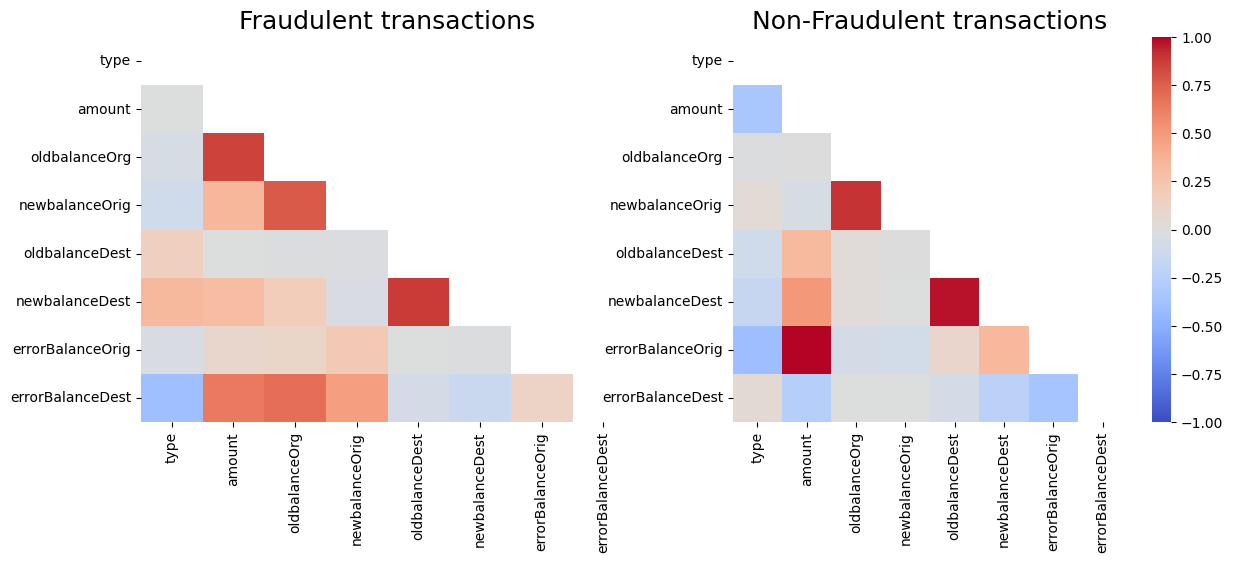

In [54]:
#Plot heatmap

corrFraud = X_fraud.iloc[:, 1:].corr()
mask = np.triu(np.ones_like(corrFraud, dtype=bool))

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

sns.heatmap(corrFraud, ax=axes[0], annot=True, cmap='coolwarm', fmt=".2f", mask=mask, annot_kws={"size":4}, vmin=-1, vmax=1, cbar=False)
axes[0].set_title('Fraudulent transactions', size = 18)

corrNonFraud = X_nonfraud.iloc[:, 1:].corr()
mask = np.triu(np.ones_like(corrNonFraud, dtype=bool))
sns.heatmap(corrNonFraud, ax=axes[1], annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size":4}, mask=mask, vmin=-1, vmax=1)
axes[1].set_title('Non-Fraudulent transactions', size = 18)


Amongst the fraudulent transactions, there is a high correlation observed between amount and errorBalanceDest and oldbalanceOrg whereas in non-fraudulent transactions high correlation is observed between amount and errorBalanceOrig.

### Model training

##### Metrics for assessing the performance of the models

As the data is imbalanced, (i.e., if we look at the target variable, imbalance between 0 and 1 counts are cleary visible) Area Under the Precision-Recall Curve (AUPRC) is used to assess the performance of the models since AUPRC is more sensitive to class imbalance and gives a more accurate picture of performance in these cases.

In [55]:
# Split the data into training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = 42)

#Scale the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Modelling using XGBoost

In [56]:
# As the data is imbalanced, lets calcualte weight i.e, ratio of number of negative class to postive class
w = (Y == 0).sum() / (Y == 1).sum()
clf = XGBClassifier(max_depth = 3, scale_pos_weight = w)
probabilities = clf.fit(X_train, Y_train).predict_proba(X_test)
auprc = average_precision_score(Y_test, probabilities[:,1])
print(f"AUPRC with XGBoost: {auprc}")

AUPRC with XGBoost: 0.9898098288389824


##### Modelling using RandomForest

In [61]:
rclf = RandomForestClassifier(n_estimators=15)
rclf.fit(X_train, Y_train)
rclf_probabilities = rclf.predict_proba(X_test)
rclf_auprc = average_precision_score(Y_test, rclf_probabilities[:,1])
print(f"AUPRC with RandomForest: {rclf_auprc}")

AUPRC with RandomForest: 0.9951534296349861


It appears from the AUPRC score that RandomForest slightly outperforms XGBoost. Let's see what are the important features for the ML model. The figure below shows that the top 5 important features were: newbalanceOrig, oldbalanceDest, newbalanceDest, errorBalanceOrig and type. 

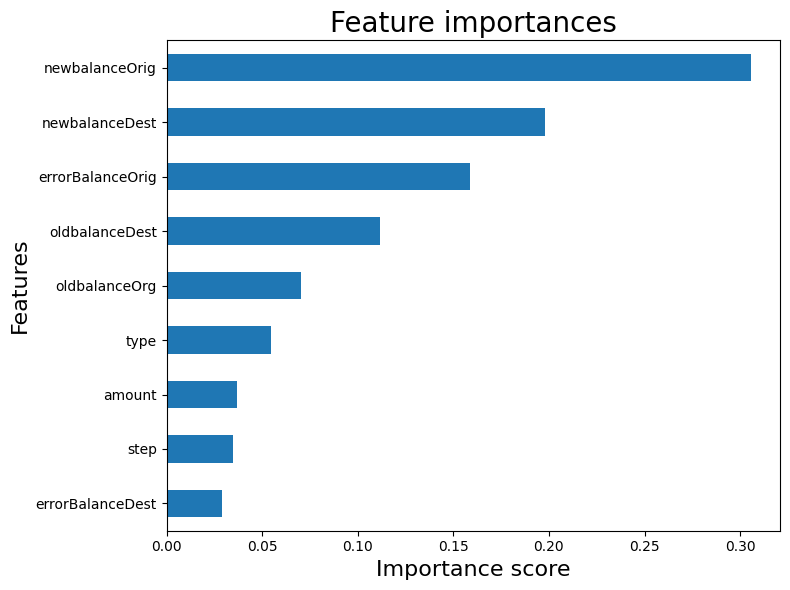

In [58]:
f_importances = pd.Series(rclf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8,6))
plt.title('Feature importances', size=20)
f_importances.plot(kind='barh')
plt.xlabel('Importance score', size=16)
plt.ylabel('Features', size=16)
plt.tight_layout()
plt.show()


In [59]:
#save the randomforest model
final_model = rclf

import pickle
with open('../model/final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
